Imports

In [1]:
import os
import warnings
from pathlib import Path
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.model_selection import train_test_split

import re
import time
import enum
from PIL import Image

import torch
from torch import nn
from torch.optim import Adam
from torchvision import transforms, datasets
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

print(os.listdir("./input"))
warnings.filterwarnings("ignore")

/home/david/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


['DATASET.md', 'wm811k-wafer-map']


Read Pickle

In [27]:
df = pd.read_pickle("./input/wm811k-wafer-map/LSWMD.pkl")
df.info()
df = df.drop(['waferIndex'], axis = 1)

def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

print(max(df.waferMapDim), min(df.waferMapDim))

print(df.info())
display(df.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB
(300, 202) (6, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   trianTestLabel  811457 non-null  object 
 4   failureType     811457 non-null  object 
 5   waferMapDim  

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"


In [28]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})
display(df.sample(10))

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
152163,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3532.0,lot9844,[],[],"(64, 71)",[],[]
491529,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...",710.0,lot30389,[],[],"(32, 29)",[],[]
783898,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1414.0,lot46423,[[Test]],[[none]],"(42, 44)",8,1
327991,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1724.0,lot19773,[],[],"(50, 43)",[],[]
610352,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",710.0,lot38375,[],[],"(32, 29)",[],[]
30488,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1,...",741.0,lot3056,[],[],"(33, 29)",[],[]
667201,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",712.0,lot41540,[],[],"(32, 29)",[],[]
557888,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",733.0,lot35078,[],[],"(31, 31)",[],[]
757521,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",1109.0,lot45348,[[Test]],[[Loc]],"(39, 37)",4,1
57251,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",710.0,lot4580,[],[],"(32, 29)",[],[]


In [29]:
tol_wafers = df.shape[0]
print(tol_wafers)

811457


In [30]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
print(df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0])

172950 25519 147431


In [31]:
df_withpattern = pd.concat([df_withpattern, df_nonpattern.iloc[:25519//8,:]], ignore_index=True)
print(df_withpattern.info())
df_withpattern["encoded_labels"] = df_withpattern["failureType"].replace(mapping_type)
print(df_withpattern.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28708 entries, 0 to 28707
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           25519 non-null  float64
 1   waferMap        28708 non-null  object 
 2   dieSize         28708 non-null  float64
 3   lotName         28708 non-null  object 
 4   trianTestLabel  28708 non-null  object 
 5   failureType     28708 non-null  object 
 6   waferMapDim     28708 non-null  object 
 7   failureNum      28708 non-null  object 
 8   trainTestNum    28708 non-null  object 
dtypes: float64(2), object(7)
memory usage: 2.0+ MB
None
          index                                           waferMap  dieSize  \
5742   199869.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   3036.0   
10361  308772.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...   1139.0   
17630  650464.0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    776.0   
10780  329592.0  [[0, 0,

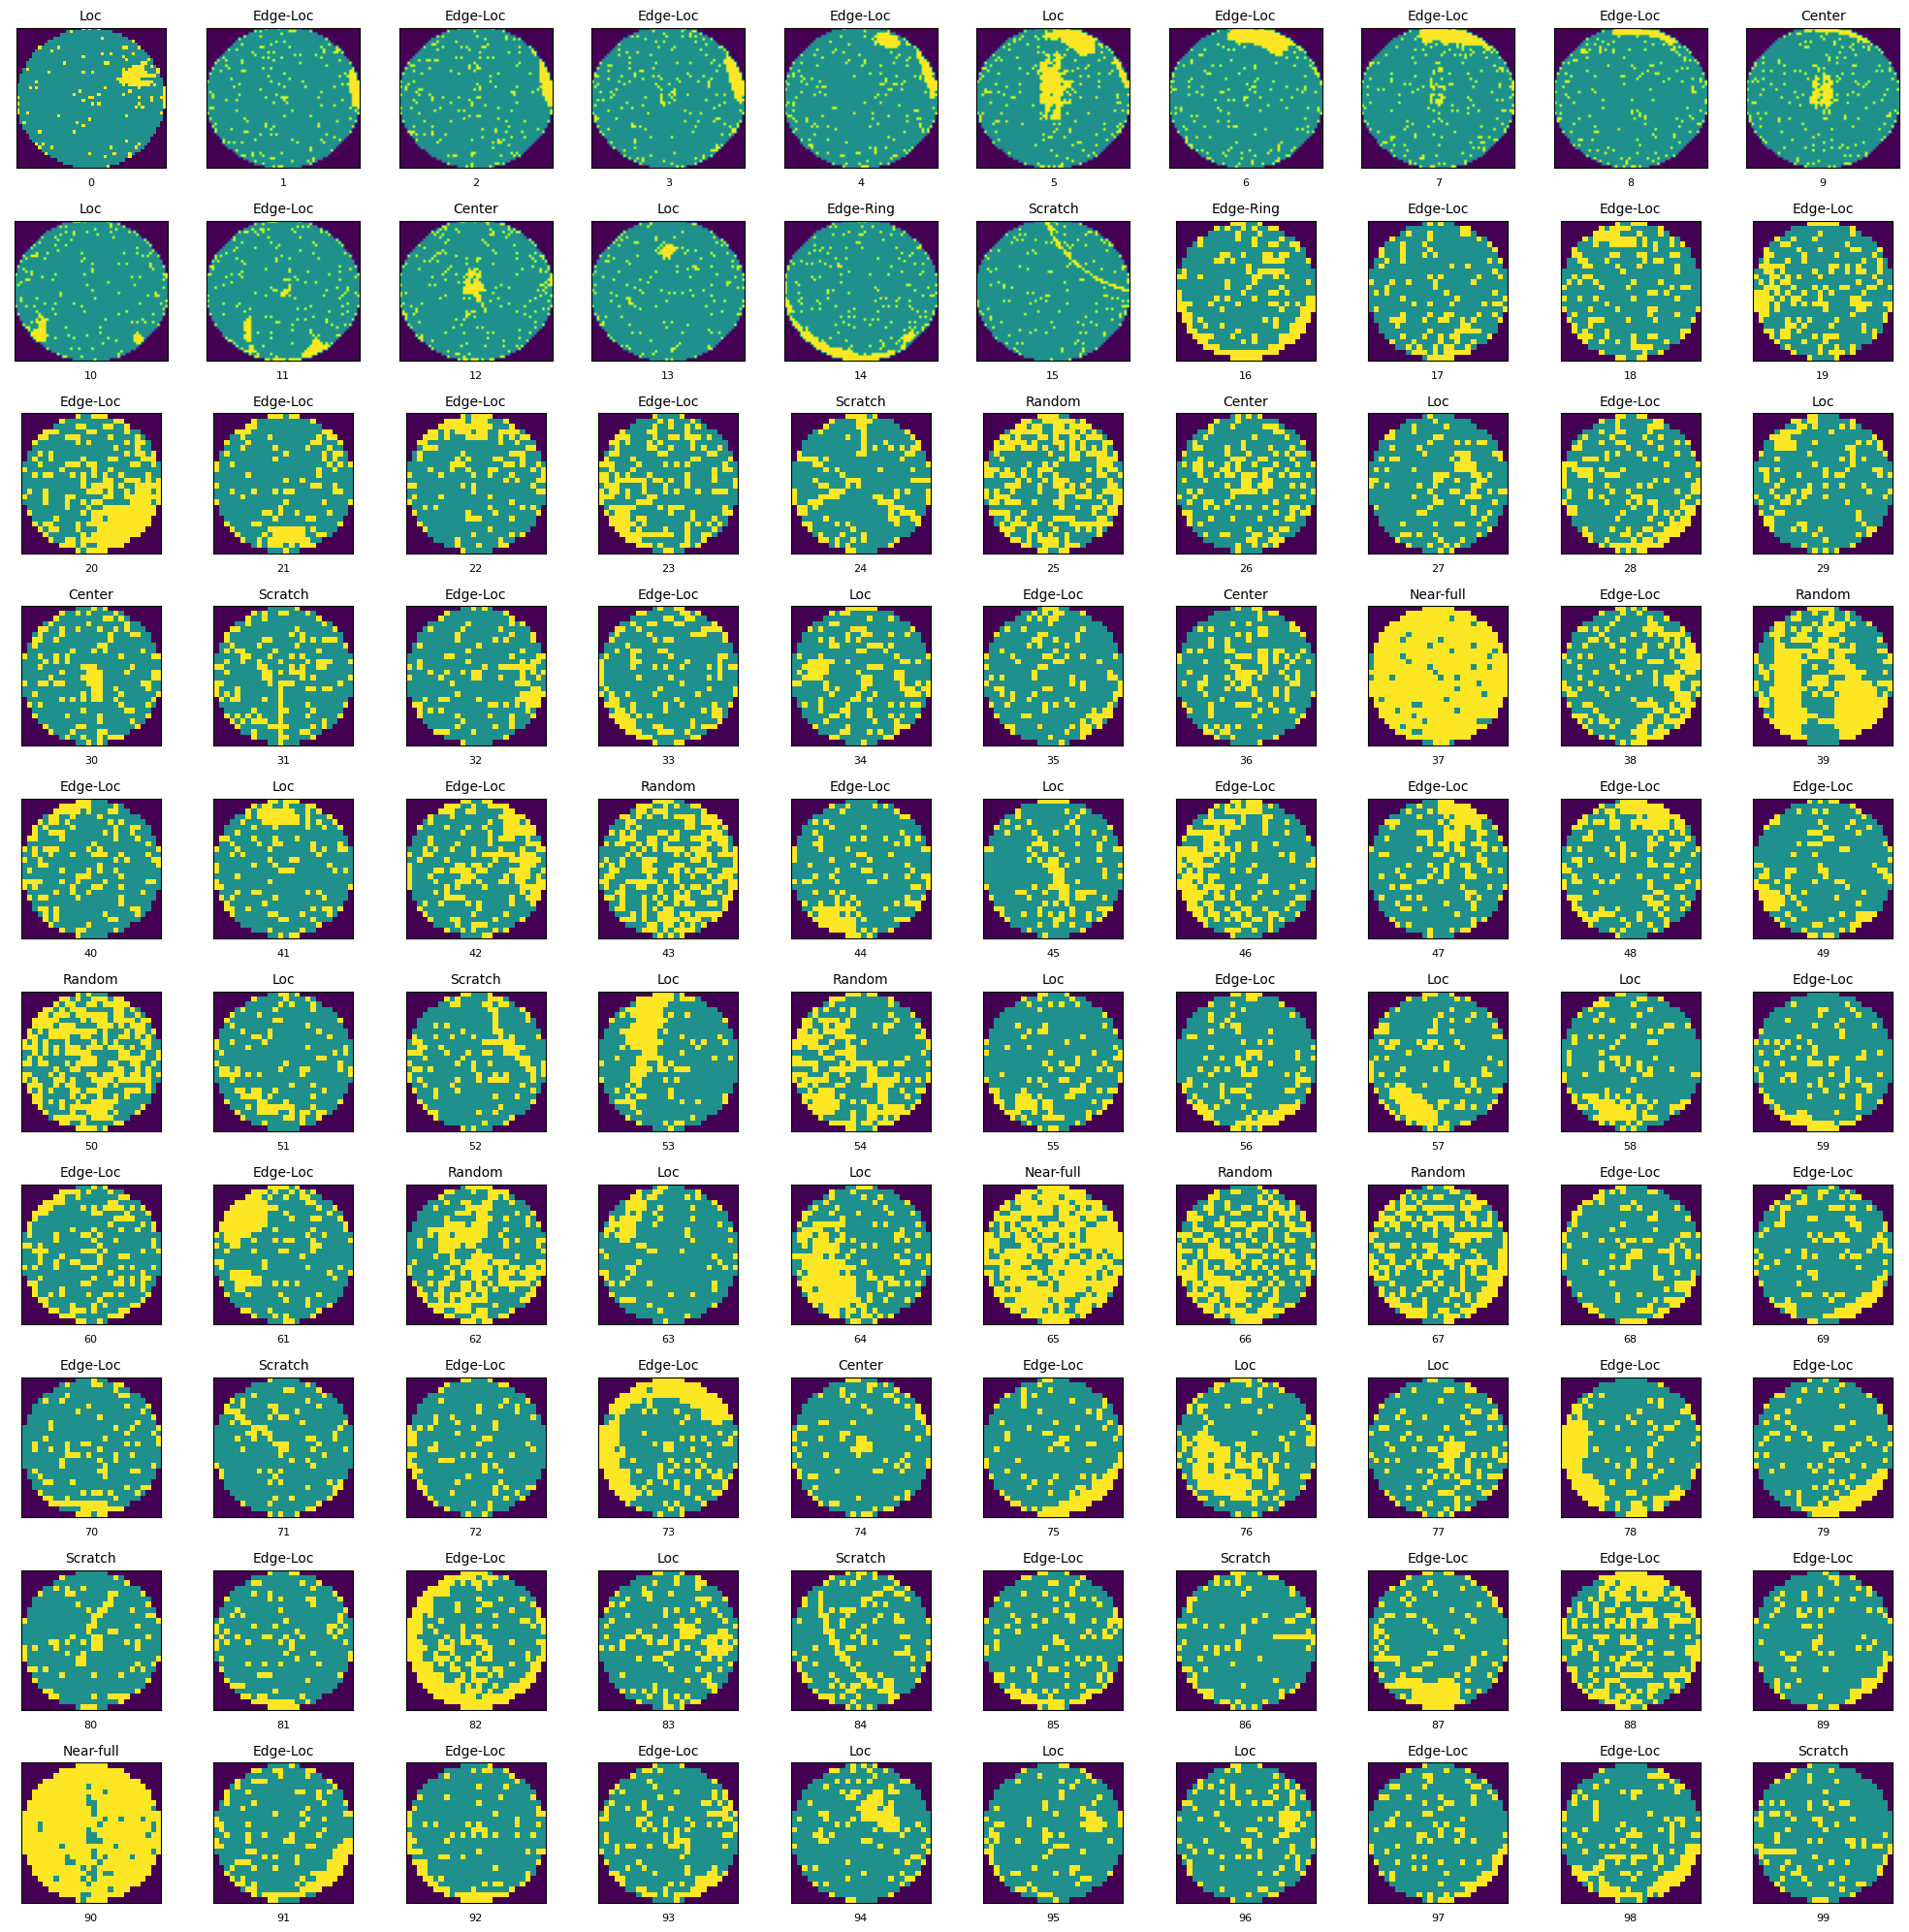

In [32]:
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(20, 20))
ax = ax.ravel(order='C')
for i in range(100):
    img = df_withpattern.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[i][0][0], fontsize=10)
    ax[i].set_xlabel(df_withpattern.index[i], fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

In [33]:
train_data_length = int(0.8*len(df_withpattern)) 
df_with_label = df_withpattern.sample(frac=1, random_state=2)
df_train, df_test = df_with_label[:train_data_length], df_with_label[train_data_length:]
df_train.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

train_data_length = int(0.75*len(df_train))
df_train, df_val = df_train[:train_data_length], df_train[train_data_length:]
print(f"training: {len(df_train)}, val: {len(df_val)}, test: {len(df_test)}, (all: {len(df_with_label)})")

# This aims to save the data into your environment.
df_train.to_pickle("dataset_train.pickle")
df_val.to_pickle("dataset_val.pickle")
df_test.to_pickle("dataset_test.pickle")
print(os.listdir())

training: 17224, val: 5742, test: 5742, (all: 28708)
['dataset_test.pickle', 'README.md', 'LICENSE', 'input', 'runs', 'LSWMD_25519.pkl', '.gitignore', 'dataset_val.pickle', 'config_class2idx.json', 'yolo_dataset.yaml', 'main.ipynb', 'yolo11n.pt', 'dataset_train.pickle', '.git']


Pickling, YAML generation etc

In [2]:
train_dir = 'yolo_dataset/train'
val_dir = 'yolo_dataset/val'
test_dir = 'yolo_dataset/test'
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
class_names = list(mapping_type.keys())
datasets_dir = 'datasets/'

output_yaml_path = 'yolo_dataset.yaml'

In [35]:
def process_wafer_map_to_image(wafer_map, output_image_path):
    """
    Convert a 2D wafer map into an image and save it.
    :param wafer_map: 2D numpy array representing the wafer map.
    :param output_image_path: Path to save the image.
    """
    # Normalize the wafer map to a range suitable for an image (0-255)
    wafer_map_normalized = (np.array(wafer_map) **7 / np.max(wafer_map)).astype(np.uint8)
    
    # Save as a grayscale image
    cv.imwrite(output_image_path, wafer_map_normalized)

def process_split(data, output_dir):
    """
    Process the split pickle file into YOLO format.
    :param split_file: Path to the pickle file.
    :param output_dir: Directory to save YOLO-formatted images and labels.
    """
    # Load the pickle file
    images_dir = os.path.join(output_dir, "images")
    labels_dir = os.path.join(output_dir, "labels")
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    for idx, row in data.iterrows():
        wafer_map = row['waferMap']  # Extract wafer map
        encoded_labels = row['encoded_labels']

        # Generate paths
        image_path = os.path.join(images_dir, f"{encoded_labels}_{idx}.png")
        label_path = os.path.join(labels_dir, f"{encoded_labels}_{idx}.txt")

        # Save the image
        process_wafer_map_to_image(wafer_map, image_path)

        # Write the label (assume whole image belongs to a single class)
        class_id = encoded_labels  # Change this if there are multiple classes
        with open(label_path, 'w') as label_file:
            # YOLO format requires <class_id> <x_center> <y_center> <width> <height>
            # Since the whole image belongs to one class, we use a bounding box that spans the image.
            label_file.write(f"{class_id} 0.5 0.5 1.0 1.0\n")

# Define output directories for each split
os.makedirs(datasets_dir + train_dir, exist_ok=True)
os.makedirs(datasets_dir + val_dir, exist_ok=True)
os.makedirs(datasets_dir + test_dir, exist_ok=True)

# Process each split
process_split(df_train, datasets_dir + train_dir)
process_split(df_val, datasets_dir + val_dir)
process_split(df_test, datasets_dir + test_dir)

data = {
        'train': train_dir,
        'val': val_dir,
        'test': test_dir,
        'nc': len(class_names),
        'names': class_names
    }
    
with open(output_yaml_path, 'w') as yaml_file:
    yaml.dump(data, yaml_file, default_flow_style=False)
    
print(f"YAML file created at {output_yaml_path}")

YAML file created at yolo_dataset.yaml


GAN to generate balanced dataset

In [3]:
import os
import yaml
import cv2 as cv
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.autograd import Variable
import torch.autograd as autograd


In [4]:
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
batch_size=128

# Load YAML config
def load_yaml_config(yaml_path):
    with open(yaml_path, 'r') as file:
        return yaml.safe_load(file)

# Custom dataset
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None, classes=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = classes
        self.image_paths = []
        self.labels = []
        self.batch_size = batch_size

        # Parse image paths and labels from filenames
        for filename in os.listdir(self.data_dir):
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                class_label = int(filename.split('_')[0])  # Extract class from 'X_YYY.png'
                if class_label in classes:
                    self.image_paths.append(os.path.join(self.data_dir, filename))
                    self.labels.append(classes.index(class_label))  # Map to index

        self.trim()
        
    def trim(self):
        length = len(self.labels)
        num_to_trim = length % batch_size

        # If the dataset size is not a multiple of the batch size, trim the excess samples
        if num_to_trim > 0:
            self.image_paths = self.image_paths[:-num_to_trim]
            self.labels = self.labels[:-num_to_trim]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms (customize as needed)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((60,60)),
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

# Load datasets using YAML config
def get_dataloaders(yaml_path, batch_size=128, num_workers=4):
    config = load_yaml_config(yaml_path)
    classes = list(mapping_type.values())

    # Create datasets
    train_dataset = CustomDataset(data_dir=datasets_dir + config['train'] + '/images', transform=transform, classes=classes)
    val_dataset = CustomDataset(data_dir=datasets_dir + config['val'] + '/images', transform=transform, classes=classes)
    test_dataset = CustomDataset(data_dir=datasets_dir + config['test'] + '/images', transform=transform, classes=classes)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader


torch.Size([128, 1, 60, 60]) tensor([0, 0, 3, 3, 3, 3, 3, 2, 3, 2, 0, 0, 2, 2, 2, 4, 2, 3, 7, 2, 0, 4, 3, 6,
        3, 3, 3, 3, 0, 3, 5, 0, 3, 0, 3, 4, 3, 0, 8, 3, 3, 2, 3, 2, 3, 4, 2, 3,
        3, 1, 4, 2, 2, 4, 2, 3, 3, 2, 6, 2, 2, 2, 3, 3, 2, 0, 3, 1, 3, 4, 6, 2,
        2, 3, 2, 2, 2, 6, 3, 8, 3, 8, 3, 0, 6, 7, 3, 3, 2, 5, 8, 2, 3, 3, 6, 3,
        3, 2, 3, 2, 4, 3, 3, 4, 8, 2, 3, 8, 4, 2, 6, 2, 4, 2, 3, 3, 8, 3, 2, 3,
        0, 3, 2, 2, 4, 3, 1, 0])


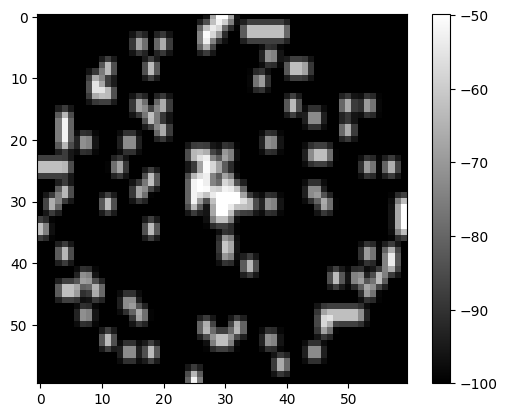

In [5]:
# Example usage
train_loader, val_loader, test_loader = get_dataloaders(output_yaml_path)

# Test the DataLoader
for images, labels in train_loader:
    print(images.shape, labels)
    temp = np.squeeze(images[0].numpy())
    temp = temp * 100
    plt.imshow(temp, cmap='gray')  # Use 'gray' for grayscale images
    plt.colorbar()  # Optional: Show a color scale
    plt.show()
    break

In [6]:
BINARIES_PATH = os.path.join(os.getcwd(), 'models', 'binaries')  # location where trained models are located
CHECKPOINTS_PATH = os.path.join(os.getcwd(), 'models', 'checkpoints')  # semi-trained models during training will be dumped here
GRAPHS_PATH = os.path.join(os.getcwd(), 'models', 'graphs')
DATA_DIR_PATH = os.path.join(os.getcwd(), 'data')  # all data both input (MNIST) and generated will be stored here
DEBUG_IMAGERY_PATH = os.path.join(DATA_DIR_PATH, 'debug_imagery')  # we'll be dumping images here during GAN training

Architecture

In [21]:
LATENT_SPACE_DIM = 100  # Latent space dimension
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor


def get_gaussian_latent_batch(batch_size, device):
    return torch.randn((batch_size, LATENT_SPACE_DIM), device=device)


class GeneratorNet(nn.Module):
    def __init__(self, img_channels=1, img_size=60):
        super(GeneratorNet, self).__init__()
        self.init_size = img_size // 4  # Downsampling by 4 (e.g., 60 -> 15 -> 7.5, rounded down)
        self.fc = nn.Sequential(nn.Linear(LATENT_SPACE_DIM, 128 * self.init_size * self.init_size))
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),  # Upsample
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Upsample
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, img_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # Output activation
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class DiscriminatorNet(nn.Module):
    def __init__(self, img_channels=1, img_size=60):
        super(DiscriminatorNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1),  # Downsample
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Downsample
            #nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * (img_size // 4) * (img_size // 4), 1),
            nn.Sigmoid()  # Output probability of real/fake
        )

    def forward(self, img):
        return self.model(img)


# Adjust optimizer learning rates for TTUR or adaptive learning
def get_optimizers(d_net, g_net):
    d_opt = Adam(d_net.parameters(), lr=0.0002, betas=(0.5, 0.999))
    g_opt = Adam(g_net.parameters(), lr=0.0002, betas=(0.5, 0.999))
    return d_opt, g_opt


In [ ]:
class GANModel:
    def __init__(
                self, 
                num_epochs, 
                train_loader, 
                batch_size=128, 
                ref_batch_size=16, 
                console_log_freq=1000, 
                debug_imagery_log_freq=1000, 
                checkpoint_freq=100, 
                ):
        self.train_loader = train_loader
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.ref_batch_size = ref_batch_size
        self.console_log_freq = console_log_freq
        self.debug_imagery_log_freq = debug_imagery_log_freq
        self.checkpoint_freq = checkpoint_freq
        self.img_cnt = 0
        self.writer = SummaryWriter()
        self.discriminator_loss_values = []
        self.generator_loss_values = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize your network models (DiscriminatorNet, GeneratorNet)
        self.discriminator_net = DiscriminatorNet().train().to(self.device)
        self.generator_net = GeneratorNet().train().to(self.device)

        # Optimizers
        self.discriminator_opt, self.generator_opt = get_optimizers(self.discriminator_net, self.generator_net)

        # Loss function
        self.adversarial_loss = nn.BCELoss()

        # Label smoothing parameters
        self.smooth_real = 0.9
        self.smooth_fake = 0.1

        # Reference batch for TensorBoard logging
        self.ref_noise_batch = get_gaussian_latent_batch(ref_batch_size, self.device)

        # Time tracking
        self.ts = time.time()

    def train(self):
        for epoch in range(self.num_epochs):
            print(f"Starting Epoch: {epoch + 1} | time elapsed = {time.time() - self.ts:.2f} [s]")
            for batch_idx, (real_images, _) in enumerate(self.train_loader):
                real_images = real_images.to(self.device)

                # Train Discriminator
                self.discriminator_opt.zero_grad()

                # Real images (with label smoothing)
                real_discriminator_output = self.discriminator_net(real_images)
                real_discriminator_loss = self.adversarial_loss(real_discriminator_output, self._get_smoothed_real_labels())

                # Fake images generated by the Generator
                fake_images = self.generator_net(get_gaussian_latent_batch(self.batch_size, self.device))
                fake_discriminator_predictions = self.discriminator_net(fake_images.detach())
                fake_discriminator_loss = self.adversarial_loss(fake_discriminator_predictions, self._get_smoothed_fake_labels())

                # Total discriminator loss
                discriminator_loss = real_discriminator_loss + fake_discriminator_loss #
                discriminator_loss.backward()
                self.discriminator_opt.step()

                # Train Generator
                self.generator_opt.zero_grad()

                generated_images_predictions = self.discriminator_net(fake_images)
                generator_loss = self.adversarial_loss(generated_images_predictions, self._get_smoothed_real_labels())

                generator_loss.backward()
                self.generator_opt.step()

                # Logging losses
                self._log_loss(discriminator_loss, generator_loss, epoch, batch_idx)

                # Save intermediate generated images
                if batch_idx % self.debug_imagery_log_freq == 0:
                    self._save_generated_images()

                # Save model checkpoints
                if (epoch + 1) % self.checkpoint_freq == 0 and batch_idx == 0:
                    self._save_checkpoint(epoch, batch_idx)

            # Save loss graph after each epoch            
            self._save_loss_graph(epoch)

    def _log_loss(self, discriminator_loss, generator_loss, epoch, batch_idx):
        # Log the losses and print status
        if batch_idx % self.console_log_freq == 0:
            elapsed_time = time.time() - self.ts
            print(f'GAN training: time elapsed = {elapsed_time:.2f} [s] | epoch={epoch + 1} | batch= [{batch_idx + 1}/{len(self.train_loader)}]')
            print(f'Discriminator Loss = {discriminator_loss.item()} | Generator Loss = {generator_loss.item()}')
        # Store losses for future analysis
        self.discriminator_loss_values.append(discriminator_loss.item())
        self.generator_loss_values.append(generator_loss.item())

    def _save_generated_images(self):
        with torch.no_grad():
            if not os.path.exists(DEBUG_IMAGERY_PATH):
                os.makedirs(DEBUG_IMAGERY_PATH)
            log_generated_images = self.generator_net(self.ref_noise_batch)
            log_generated_images_resized = nn.Upsample(scale_factor=2.5, mode='nearest')(log_generated_images)
            out_path = os.path.join(DEBUG_IMAGERY_PATH, f'{str(self.img_cnt).zfill(6)}.jpg')
            save_image(log_generated_images_resized, out_path, nrow=int(np.sqrt(self.ref_batch_size)), normalize=True)
            self.img_cnt += 1

    def _save_checkpoint(self, epoch, batch_idx):
        if not os.path.exists(CHECKPOINTS_PATH):
            os.makedirs(CHECKPOINTS_PATH)
        
        # Define checkpoint file name
        ckpt_model_name = f"vanilla_ckpt_epoch_{epoch + 1}_batch_{batch_idx + 1}.pth"
        checkpoint_path = os.path.join(CHECKPOINTS_PATH, ckpt_model_name)
        
        # Create checkpoint dictionary with model and optimizer states
        checkpoint = {
            "generator_state_dict": self.generator_net.state_dict(),
            "discriminator_state_dict": self.discriminator_net.state_dict(),
            "generator_optimizer_state_dict": self.generator_opt.state_dict(),
            "discriminator_optimizer_state_dict": self.discriminator_opt.state_dict(),
            "epoch": epoch,
            "Dloss": self.discriminator_loss_values,
            "GLoss": self.generator_loss_values,
        }
        # Save checkpoint to file
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")

    def _save_loss_graph(self, epoch):
        if not os.path.exists(GRAPHS_PATH):
            os.makedirs(GRAPHS_PATH)
        plt.figure(figsize=(10, 5))
        plt.plot(self.discriminator_loss_values, label='Discriminator Loss')

        plt.plot(self.generator_loss_values, label='Generator Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        # plt.ylim(0,3)
        plt.title(f'Losses over Epochs (Epoch {epoch + 1})')
        plt.legend()

        # Save the plot to the 'graphs' directory
        graph_path = os.path.join(GRAPHS_PATH, f'loss_graph.png')
        plt.savefig(graph_path)
        plt.close()  # Close the plot to free up memory

    def _get_smoothed_real_labels(self):
        return torch.full((self.batch_size, 1), self.smooth_real, device=self.device)

    def _get_smoothed_fake_labels(self):
        return torch.full((self.batch_size, 1), self.smooth_fake, device=self.device)

In [ ]:
# Hyperparameters
num_epochs = 1000 # 9 min

# Create GANModel and start training
gan_model = GANModel(num_epochs, train_loader)
gan_model.train()

Starting Epoch: 1 | time elapsed = 0.00 [s]
GAN training: time elapsed = 0.15 [s] | epoch=1 | batch= [1/134]
Discriminator Loss = 1.407081127166748 | Generator Loss = 0.6333507299423218
GAN training: time elapsed = 4.05 [s] | epoch=1 | batch= [101/134]
Discriminator Loss = 1.366639256477356 | Generator Loss = 0.7124501466751099
Starting Epoch: 2 | time elapsed = 5.43 [s]
GAN training: time elapsed = 5.57 [s] | epoch=2 | batch= [1/134]
Discriminator Loss = 1.4007785320281982 | Generator Loss = 0.5649020671844482
Checkpoint saved to /home/david/Wafer-Defect-CNN/models/checkpoints/vanilla_ckpt_epoch_2_batch_1.pth
GAN training: time elapsed = 9.32 [s] | epoch=2 | batch= [101/134]
Discriminator Loss = 1.3782970905303955 | Generator Loss = 0.7124805450439453
Starting Epoch: 3 | time elapsed = 10.62 [s]
GAN training: time elapsed = 10.76 [s] | epoch=3 | batch= [1/134]
Discriminator Loss = 1.4009634256362915 | Generator Loss = 0.7173094749450684
GAN training: time elapsed = 14.23 [s] | epoch=3

In [48]:
from ultralytics import YOLO
output_yaml_path = 'yolo_dataset.yaml'

model = YOLO("yolo11n.pt")
results = model.train(data=output_yaml_path, epochs=1, imgsz=60)

New https://pypi.org/project/ultralytics/8.3.36 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.34 🚀 Python-3.8.10 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8192MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=yolo_dataset.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=60, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr

train: Scanning /home/david/Wafer-Defect-CNN/datasets/yolo_dataset/train/labels... 1309 images, 0 backgrounds, 0 corrupt:   8%|▊         | 1309/17224 [00:01<00:12, 1289.98it/s]


KeyboardInterrupt: 

In [ ]:
from ultralytics import YOLO
output_yaml_path = 'yolo_dataset.yaml'

m1 = YOLO("runs/detect/train/weights/last.pt")
r1 = m1.train(data=output_yaml_path, epochs=30, imgsz=60)

Ultralytics 8.3.34 🚀 Python-3.8.10 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8192MiB)
engine/trainer: task=detect, mode=train, model=runs/detect/train5/weights/last.pt, data=yolo_dataset.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=300, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=

/home/david/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

train: Scanning /home/david/Wafer-Defect-CNN/datasets/yolo_dataset/train/labels.cache... 17224 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17224/17224 [00:00<?, ?it/s]
val: Scanning /home/david/Wafer-Defect-CNN/datasets/yolo_dataset/val/labels.cache... 5742 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5742/5742 [00:00<?, ?it/s]


Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 8 dataloader workers
Logging results to runs/detect/train6
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30     0.721G     0.2129     0.9277     0.9223         24        320: 100%|██████████| 1077/1077 [01:51<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:23<00:00,  7.71it/s]


                   all       5742       5742       0.41      0.611      0.516      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30     0.707G     0.2214      0.875     0.9197         20        320: 100%|██████████| 1077/1077 [01:43<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:23<00:00,  7.67it/s]

                   all       5742       5742      0.662      0.728      0.737      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      0.69G     0.2032      0.808     0.9142         23        320: 100%|██████████| 1077/1077 [01:39<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:23<00:00,  7.70it/s]

                   all       5742       5742      0.579      0.705       0.69      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30     0.692G     0.1814     0.7607     0.9095         29        320: 100%|██████████| 1077/1077 [01:38<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:22<00:00,  7.83it/s]

                   all       5742       5742      0.766      0.749       0.85      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30     0.692G     0.1626     0.7229     0.9047         22        320: 100%|██████████| 1077/1077 [01:37<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:23<00:00,  7.74it/s]


                   all       5742       5742      0.753      0.701      0.763       0.71

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30     0.694G      0.149     0.6911     0.9037         28        320: 100%|██████████| 1077/1077 [01:37<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:23<00:00,  7.75it/s]


                   all       5742       5742      0.789      0.716      0.841      0.824

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30     0.688G     0.1396     0.6729     0.9018         18        320: 100%|██████████| 1077/1077 [01:37<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:23<00:00,  7.68it/s]

                   all       5742       5742      0.816      0.751      0.882      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30     0.688G     0.1311     0.6525     0.9001         21        320: 100%|██████████| 1077/1077 [01:38<00:00, 10.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:22<00:00,  7.92it/s]


                   all       5742       5742      0.775      0.814      0.872      0.851

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30     0.688G     0.1241      0.636     0.8977         22        320: 100%|██████████| 1077/1077 [01:38<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:22<00:00,  7.94it/s]


                   all       5742       5742      0.731      0.723      0.731      0.725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      0.69G     0.1183     0.6231     0.8971         28        320: 100%|██████████| 1077/1077 [01:39<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:23<00:00,  7.52it/s]

                   all       5742       5742      0.849      0.839       0.91      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30     0.688G      0.114     0.6151     0.8965         19        320: 100%|██████████| 1077/1077 [01:38<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:23<00:00,  7.78it/s]

                   all       5742       5742      0.826      0.758      0.837      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      0.69G     0.1096     0.6075     0.8959         26        320: 100%|██████████| 1077/1077 [01:38<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:23<00:00,  7.79it/s]

                   all       5742       5742      0.811      0.837      0.885      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30     0.688G     0.1023     0.5919     0.8944         22        320: 100%|██████████| 1077/1077 [01:38<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:23<00:00,  7.79it/s]


                   all       5742       5742       0.87       0.82      0.907      0.886

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30     0.692G    0.09881     0.5875     0.8958         26        320: 100%|██████████| 1077/1077 [01:37<00:00, 11.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:22<00:00,  7.88it/s]

                   all       5742       5742       0.86      0.817      0.894      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30     0.688G    0.09719     0.5793     0.8934         22        320: 100%|██████████| 1077/1077 [01:37<00:00, 11.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:22<00:00,  7.83it/s]


                   all       5742       5742      0.878      0.801       0.91      0.901

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30     0.688G    0.09254     0.5677     0.8942         27        320: 100%|██████████| 1077/1077 [01:38<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:22<00:00,  7.86it/s]

                   all       5742       5742      0.847      0.804      0.891      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30     0.688G    0.08992     0.5631     0.8918         25        320: 100%|██████████| 1077/1077 [01:38<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:22<00:00,  7.93it/s]


                   all       5742       5742      0.817      0.833      0.913      0.908

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      0.69G    0.08714     0.5511     0.8919         22        320: 100%|██████████| 1077/1077 [01:38<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:23<00:00,  7.77it/s]

                   all       5742       5742      0.856      0.791      0.884      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      0.69G    0.08201     0.5411     0.8901         26        320: 100%|██████████| 1077/1077 [01:38<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:23<00:00,  7.83it/s]

                   all       5742       5742      0.852      0.789      0.892      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30     0.688G    0.08033     0.5397     0.8905         23        320: 100%|██████████| 1077/1077 [01:38<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:23<00:00,  7.73it/s]

                   all       5742       5742      0.856      0.835      0.908        0.9


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30     0.686G     0.0387     0.3387     0.8997          8        320: 100%|██████████| 1077/1077 [01:39<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:23<00:00,  7.78it/s]

                   all       5742       5742        0.9      0.899      0.957      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30     0.688G    0.02899     0.2829     0.8982          8        320: 100%|██████████| 1077/1077 [01:38<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:23<00:00,  7.78it/s]

                   all       5742       5742      0.906      0.918      0.966      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30     0.686G    0.02591     0.2619      0.897          8        320: 100%|██████████| 1077/1077 [01:38<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:23<00:00,  7.79it/s]

                   all       5742       5742      0.911      0.873      0.956      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30     0.686G    0.02399     0.2416     0.8963          8        320: 100%|██████████| 1077/1077 [01:38<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:23<00:00,  7.71it/s]

                   all       5742       5742       0.91      0.889      0.966      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30     0.686G    0.02241     0.2291      0.897          8        320: 100%|██████████| 1077/1077 [01:38<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:23<00:00,  7.80it/s]

                   all       5742       5742      0.917      0.924       0.97       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30     0.688G    0.02064     0.2112     0.8965          8        320: 100%|██████████| 1077/1077 [01:38<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:23<00:00,  7.75it/s]

                   all       5742       5742      0.924       0.94      0.973      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30     0.686G     0.0191     0.2056     0.8959          8        320: 100%|██████████| 1077/1077 [01:38<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:23<00:00,  7.73it/s]


                   all       5742       5742      0.941      0.925      0.975      0.975

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30     0.686G    0.01768      0.195      0.896          8        320: 100%|██████████| 1077/1077 [01:38<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:23<00:00,  7.81it/s]

                   all       5742       5742      0.939      0.921      0.974      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30     0.686G    0.01648     0.1837     0.8951          8        320: 100%|██████████| 1077/1077 [01:44<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:23<00:00,  7.70it/s]


                   all       5742       5742      0.932       0.93      0.975      0.975

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30     0.688G    0.01469     0.1765     0.8965          8        320: 100%|██████████| 1077/1077 [01:38<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:23<00:00,  7.72it/s]

                   all       5742       5742      0.926       0.94      0.976      0.976



30 epochs completed in 1.026 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 5.4MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics 8.3.34 🚀 Python-3.8.10 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8192MiB)
YOLO11n summary (fused): 238 layers, 2,583,907 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 180/180 [00:26<00:00,  6.91it/s]


                   all       5742       5742      0.927      0.939      0.976      0.976
                Center        843        843      0.972      0.962      0.992      0.992
                 Donut        105        105      0.915      0.848      0.963      0.963
              Edge-Loc       1048       1048      0.884      0.967      0.979      0.979
             Edge-Ring       1988       1988      0.988      0.989      0.995      0.995
                   Loc        697        697      0.822      0.888      0.931      0.931
                Random        173        173      0.964      0.935      0.984      0.984
               Scratch        224        224      0.938      0.879      0.951      0.951
             Near-full         24         24      0.892          1      0.995      0.995
                  none        640        640      0.966      0.983      0.993      0.993
Speed: 0.0ms preprocess, 0.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect